# Foreword

This script prepares and preprocesses the inputs of a WFlow hydrological model.hgjhg

# Import packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import rasterio as rio
import os
import glob
from urllib.request import Request, urlopen
from io import StringIO
from dateutil import parser
from sqlalchemy import create_engine
from whitebox import WhiteboxTools
from bmi_topography import Topography
from bs4 import BeautifulSoup
import pyflwdir
import cdsapi
import contextily as cx
import psycopg2
import matplotlib.pyplot as plt
from matplotlib import colors
import contextily as cx
from shapely.geometry import Point, Polygon, box
from matplotlib_scalebar.scalebar import ScaleBar
import imageio
import getpass, json, time
import requests as r
from datetime import datetime
from hydromt import DataCatalog, flw

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set project root directory
root = '/Users/aprida/Documents/Consulting/Private_sector/Keolis'

# Read AOI if generated previously
try:
    gdf_aoi = gpd.read_file(f'{root}/Model_Alvaro/Inputs/basin_saone_hydrology.geojson')
    gdf_aoi_bounds = gdf_aoi.bounds
    print('AOI available.')
except:
    print('AOI not available.')

AOI available.


## PostGIS Setup

In [3]:
# PostGis DB credentials
dbname = "aprida"
dbuser = "postgres"
dbpass = "postgres"
dbhost = "localhost"
dbport = "5432"

db_connection_url = 'postgresql://' + dbuser + ':' + dbpass + '@' + dbhost + ':' + dbport + '/' + dbname
con = create_engine(db_connection_url)

## WhiteBox Tools Setup

In [4]:
# Documentation about Hydrological functions here: https://www.whiteboxgeo.com/manual/wbt_book/available_tools/hydrological_analysis.html

wbt = WhiteboxTools()
wbt.set_whitebox_dir(r'/Applications/WBT')

def wbt_print_callback(value):
    pass

wbt.set_default_callback(wbt_print_callback)

# Identify river gauges in the surroundings of Lyon

## Delineation of the upstream basin from outlet

In [5]:
# Define outlet (upstream boundary condition of hydraulic model)
outlet_lon = [4.83143]
outlet_lat = [46.29591]
outlet_name = 'Saone_outlet'

df_outlet = pd.DataFrame({'name': outlet_name, 'longitude': outlet_lon, 'latitude': outlet_lat})
gdf_outlet = gpd.GeoDataFrame(data=df_outlet, geometry=gpd.points_from_xy(outlet_lon, outlet_lat), crs=4326)
crs_utm = gdf_outlet.estimate_utm_crs()
crs_utm

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
sql = "SELECT hybas_id, next_down, geom FROM hybas_eu_lev09_v1c" # HydroBASINS Level 9
gdf_watersheds = gpd.GeoDataFrame.from_postgis(sql, con)
sql = "SELECT hyriv_id, geom FROM hydrorivers_v10_eu" # HydroRIVERS
gdf_rivers = gpd.GeoDataFrame.from_postgis(sql, con)

In [7]:
# Identify the HydroBASINS Level 9 where the POI is located

sql_req = """
WITH outlet AS ( SELECT (ST_SetSRID(ST_MakePoint({}, {}),4326)) AS pt)
SELECT hybas_id FROM hybas_eu_lev09_v1c AS watershed
CROSS JOIN outlet
WHERE ST_WITHIN(outlet.pt,watershed.geom);""".format(outlet_lon[0],outlet_lat[0])
conn = psycopg2.connect(host=dbhost, port=dbport, database=dbname, user=dbuser, password=dbpass)
cursor = conn.cursor()
cursor.execute(sql_req)
data = cursor.fetchone()
hybas_id = data[0]
cursor.close()
conn.close()
print("Watershed ID: ", int(hybas_id))
gdf_watershed_sel = gdf_watersheds[gdf_watersheds.hybas_id==hybas_id]

list_ids = [hybas_id]

while len(list_ids) > 0:
    
    list_ids_new = []
    
    for ids in list_ids:

        gdf = gdf_watersheds[gdf_watersheds.next_down==ids]
        gdf_watershed_sel = pd.concat([gdf, gdf_watershed_sel], ignore_index=True)
        list_ids_new.append(list(gdf.hybas_id))

    list_ids = list(pd.DataFrame(list_ids_new).stack())

gdf_watershed_sel_dissolve = gdf_watershed_sel.dissolve()
gdf_watershed_sel_dissolve.to_file(os.path.join(root, f'Hydrography/{outlet_name}.geojson'))

gdf_aoi = gpd.GeoDataFrame(geometry=[box(*gdf_watershed_sel_dissolve.total_bounds)]).buffer(0.1, join_style=2)
gdf_aoi.to_file(f'{root}/Model_Alvaro/Inputs/basin_saone_hydrology.geojson')
gdf_aoi_bounds = gdf_aoi.bounds

Watershed ID:  2090524070


In [8]:
# Identify upstream 

url_base = 'https://hubeau.eaufrance.fr/api/v1/hydrometrie'
url_stations = os.path.join(url_base, 'referentiel/stations.csv?&size=10000')

with urlopen(Request(url_stations)) as reponse:
    soup = BeautifulSoup(reponse.read(), 'html.parser')
    df_stations_all = pd.read_csv(StringIO(str(soup)), sep = ';')
    
gdf_stations_all = gpd.GeoDataFrame(df_stations_all, geometry=gpd.points_from_xy(df_stations_all.longitude_station, df_stations_all.latitude_station), crs=4326)

gdf_stations_sel = gpd.sjoin(gdf_stations_all, gdf_watershed_sel, predicate='within').reset_index(drop=True)
gdf_stations_sel = gdf_stations_sel[['code_station', 'libelle_station', 'type_station', 'libelle_cours_eau', 'date_ouverture_station',
                'date_fermeture_station', 'code_sandre_reseau_station', 'date_debut_ref_alti_station',
                  'date_activation_ref_alti_station', 'date_maj_ref_alti_station', 'en_service', 'geometry']][gdf_stations_sel['en_service']==True].reset_index(drop=True)
gdf_stations_sel = gdf_stations_sel[gdf_stations_sel['date_ouverture_station'].notna()].reset_index(drop=True)
gdf_stations_sel['yrs_of_record'] = gdf_stations_sel.apply(lambda row: (datetime.now().date() - parser.parse(row.date_ouverture_station).date()).days/365, axis=1)
gdf_stations_sel = gdf_stations_sel[gdf_stations_sel['yrs_of_record'] > 20].reset_index(drop=True) # Filter minimum number of years of record on station

gdf_stations_sel.to_file(root + '/Hydrography/Gauges_Saone.geojson')
gdf_stations_sel.to_csv(root + '/Hydrography/Gauges_Saone.csv', index=False)

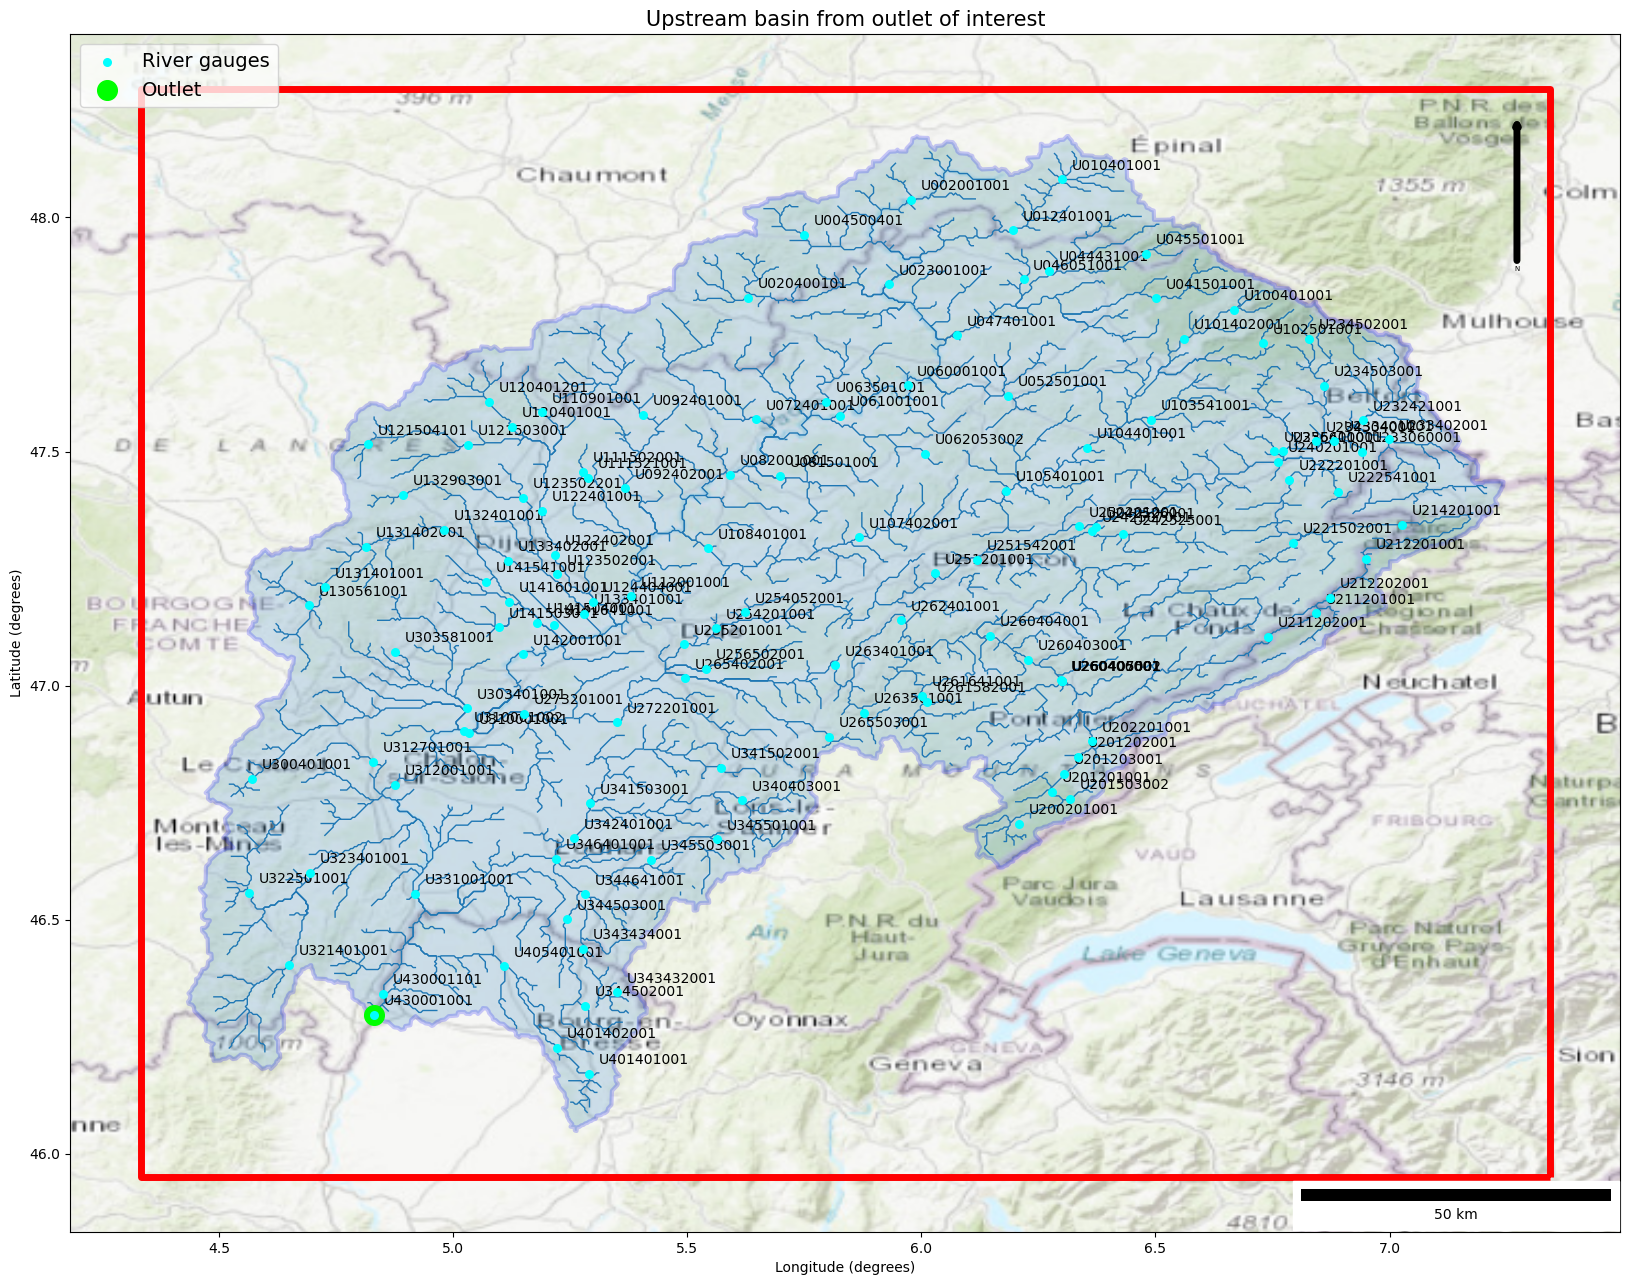

In [9]:
# Identify the HydroRivers for the upstream basin (viz purposes only)

gdf_rivers_sel = gpd.sjoin(gdf_rivers, gdf_watershed_sel, predicate='intersects').reset_index(drop=True)

# Plot river stations at upstream basin and area where assets are located

fig, ax = plt.subplots(figsize=(20,25))

gdf_watershed_sel_dissolve.plot(ax=ax, alpha=0.2, edgecolor='blue', linewidth=3, zorder=1)
gdf_stations_sel.plot(ax=ax, marker='o', color='cyan', markersize=30, label='River gauges', zorder=4)
gdf_outlet.plot(ax=ax, marker='o', color='lime', markersize=200, label='Outlet', zorder=3)
gdf_rivers_sel.plot(ax=ax, linewidth=1)
gdf_aoi.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=5)
ax.legend(loc="upper left", fontsize=14)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_title(label="Upstream basin from outlet of interest", fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

# Add station IDs
for x, y, label in zip(gdf_stations_sel.geometry.x, gdf_stations_sel.geometry.y, gdf_stations_sel.code_station):
    ax.annotate(label, xy=(x, y), xytext=(7, 7), textcoords="offset points", color='black', fontsize=10)

# Add a compass sign (north arrow) to the map
arrow_length = max(abs((ax.get_xlim()[1] - ax.get_xlim()[0]) / 10), abs((ax.get_ylim()[1] - ax.get_ylim()[0]) / 8))  # Length of the arrow
arrow_text = 'N'  # Text to display for the north direction
arrow_props = dict(facecolor='black', edgecolor='black', arrowstyle='->', linewidth=5)

# Adjust the arrow position based on your map dimensions
arrow_x = ax.get_xlim()[1]  - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 15  # X-coordinate (0.5 for the center)
arrow_y = ax.get_ylim()[1]  - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 15  # Y-coordinate (0.9 for the top)

ax.annotate(arrow_text, xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - arrow_length),
            arrowprops=arrow_props, ha='center', va='center', fontsize=5, color='black')

# Add a distance scale bar

points = gpd.GeoSeries(
    [Point(gdf_watershed_sel_dissolve.geometry.centroid.x, gdf_watershed_sel_dissolve.geometry.centroid.y),
     (Point(gdf_watershed_sel_dissolve.geometry.centroid.x - 1, gdf_watershed_sel_dissolve.geometry.centroid.y))],
    crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs_utm)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters, location='lower right', length_fraction=0.25, pad=0.6))


In [40]:
list_stations

2
3
4
5
6


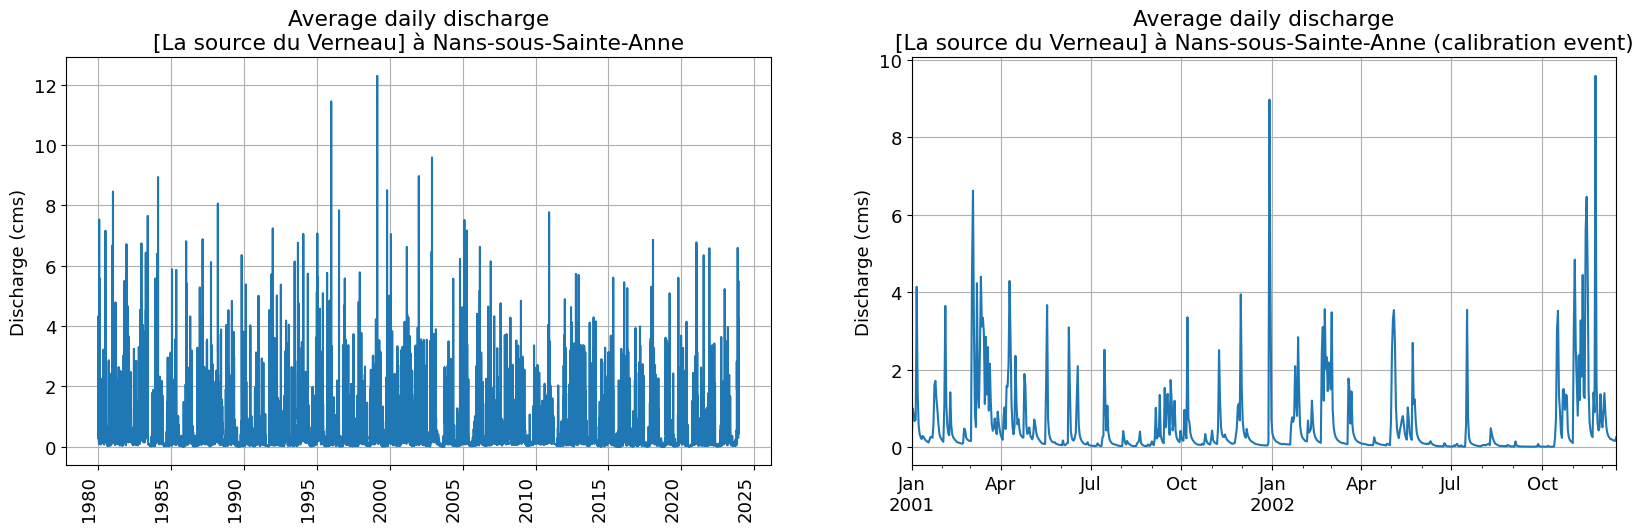

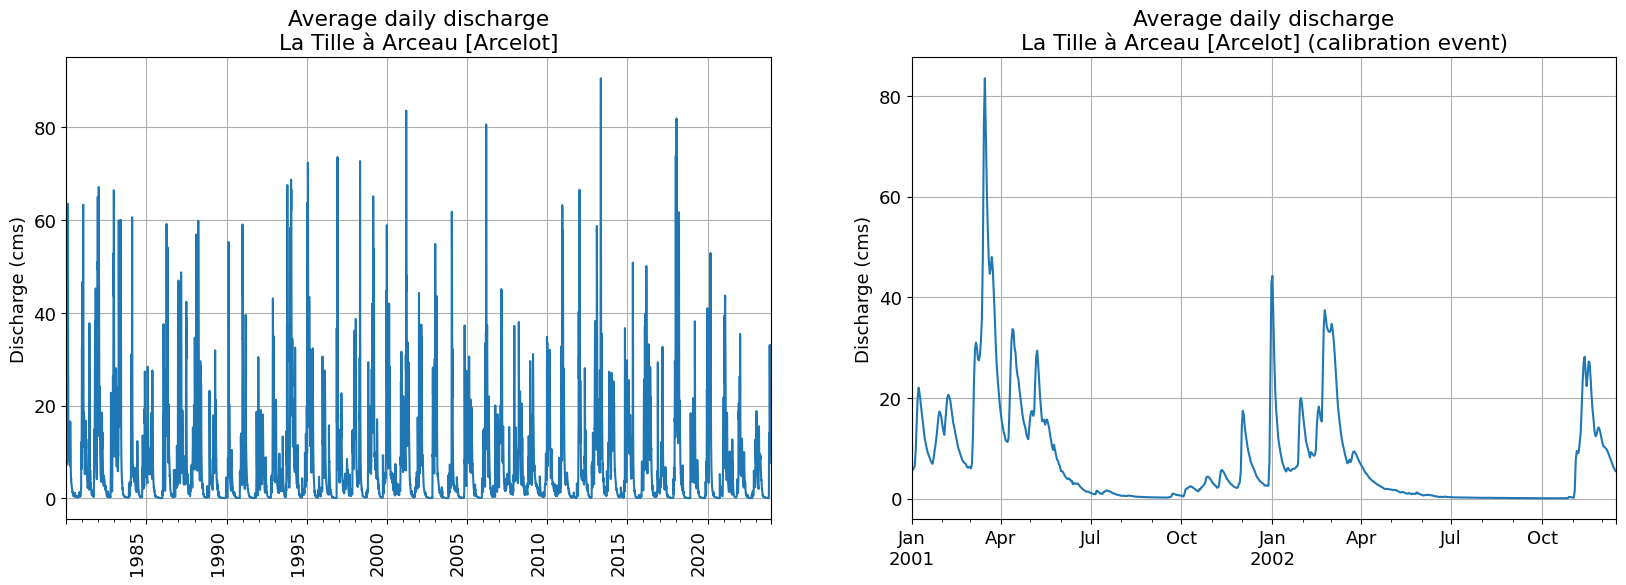

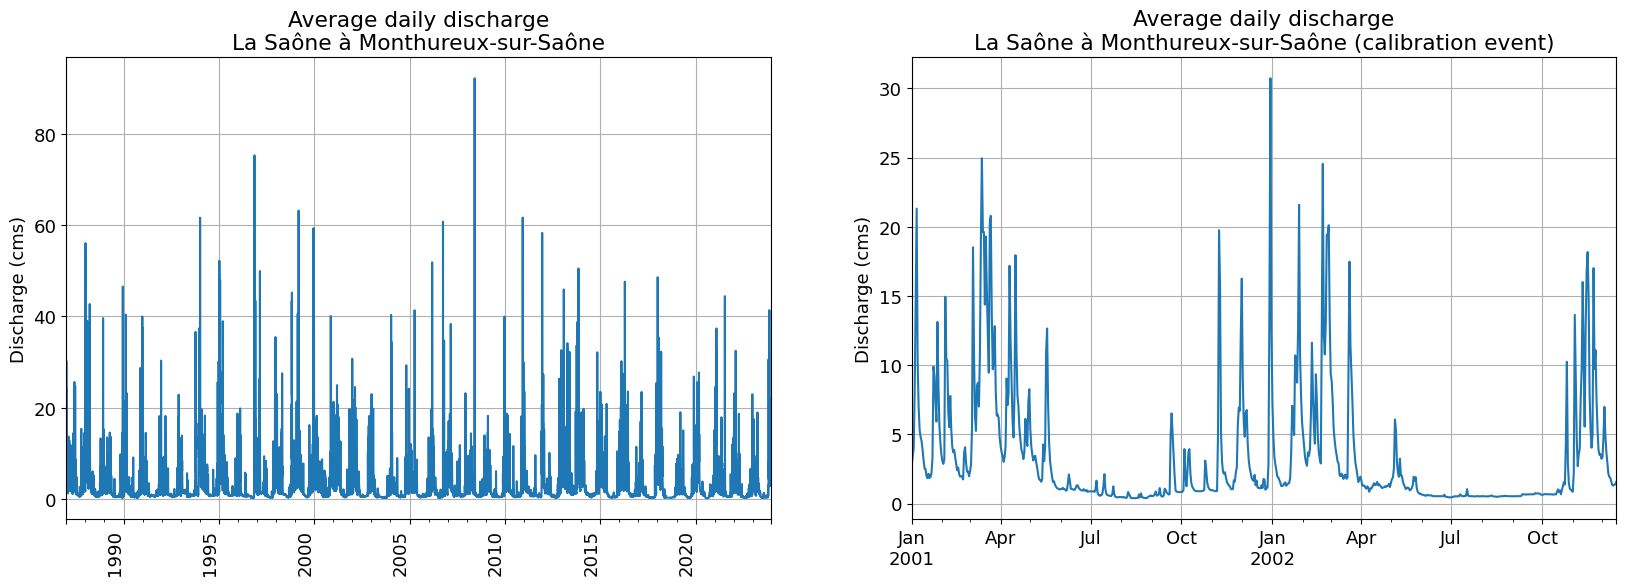

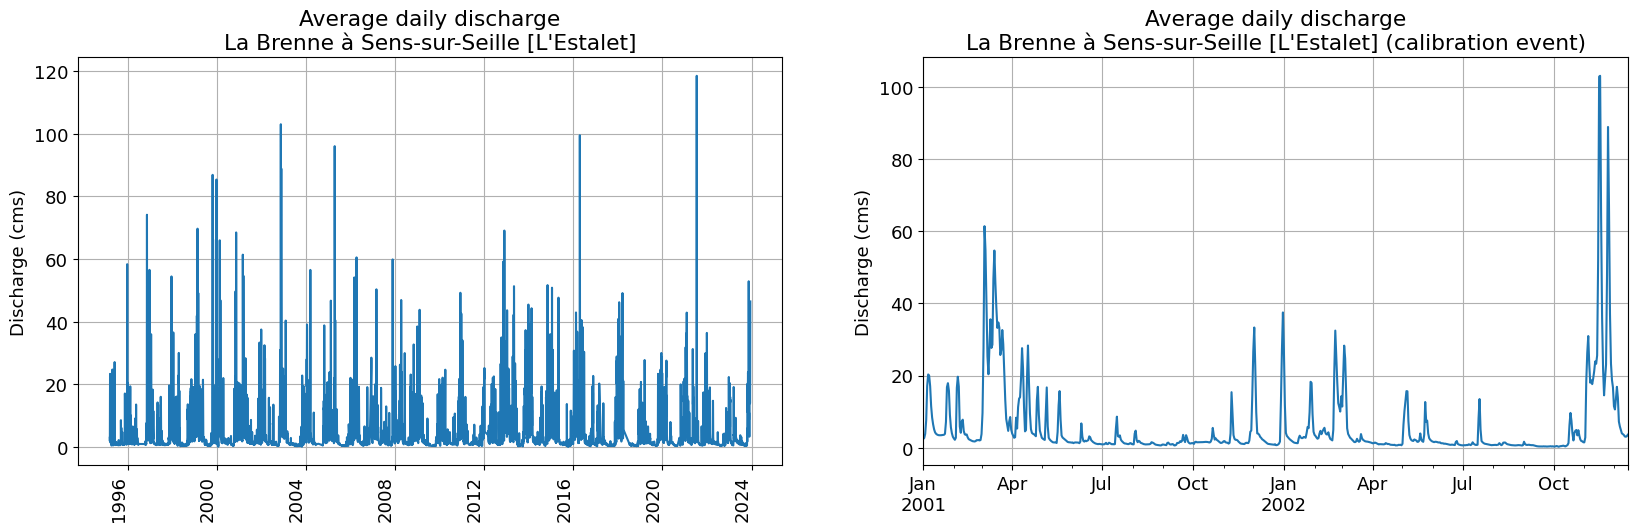

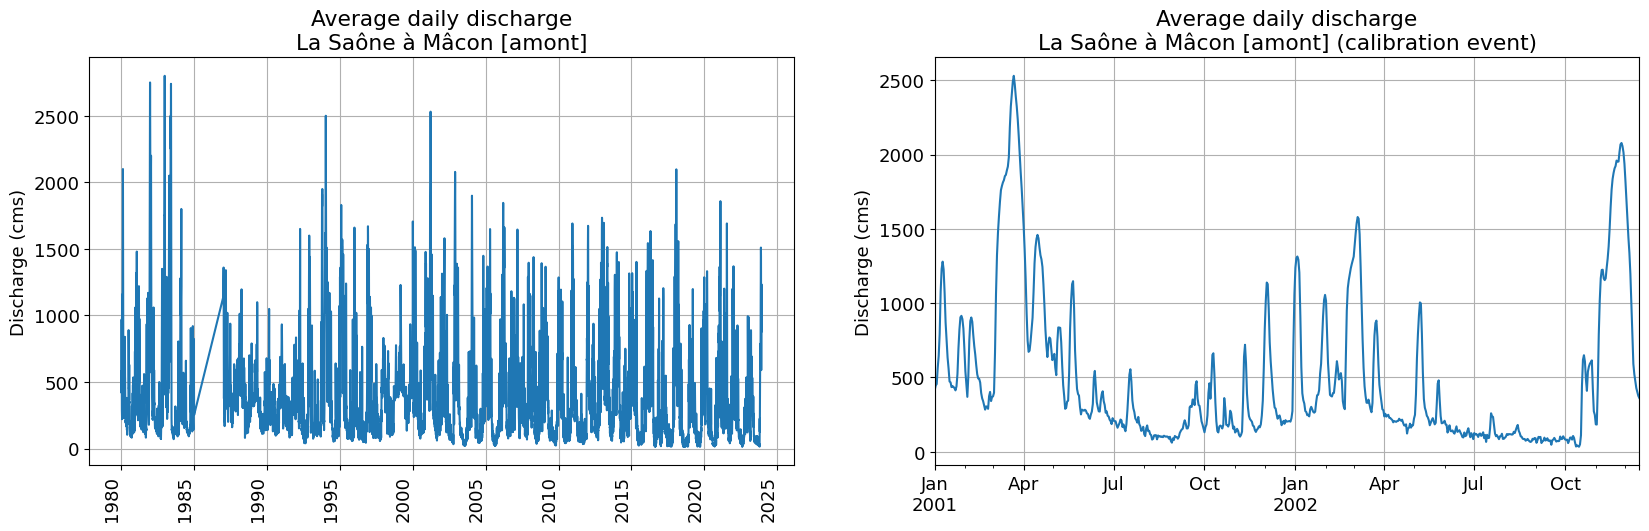

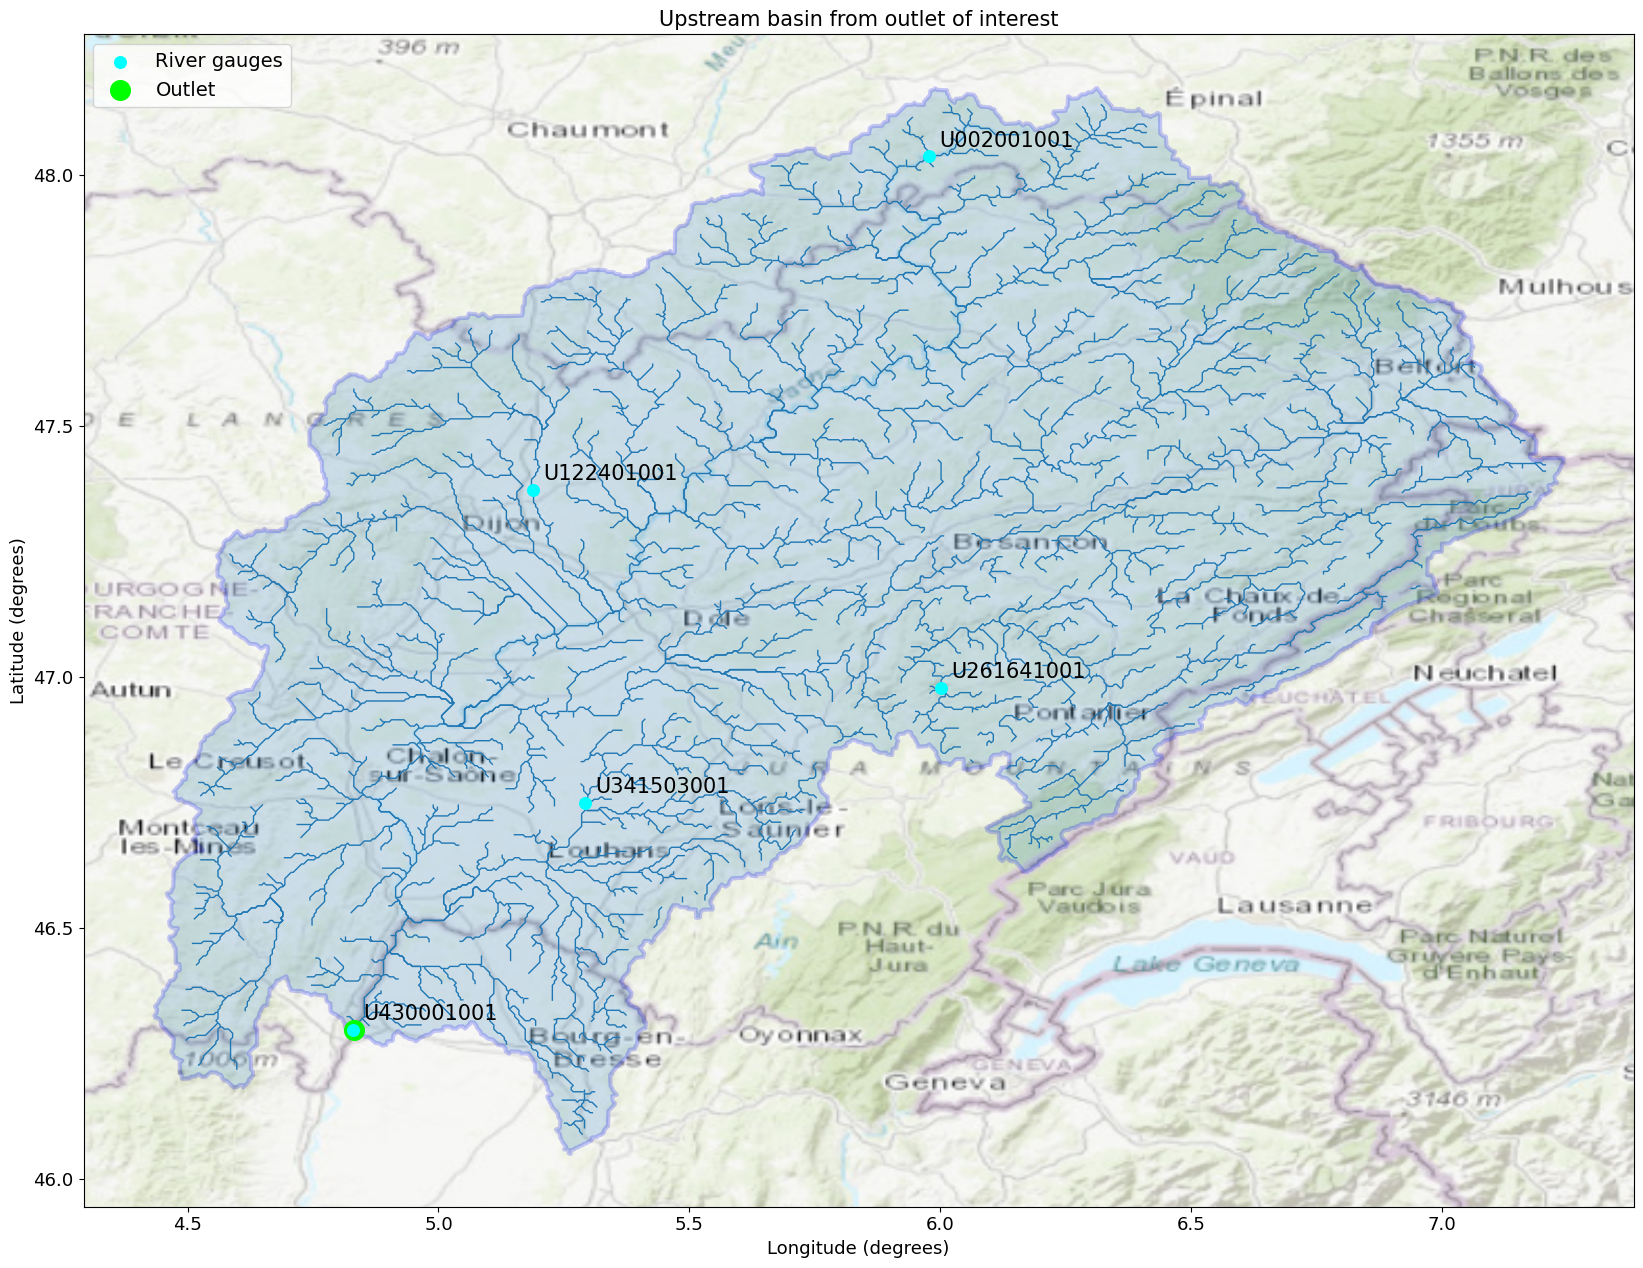

In [42]:
# # Select some stations upstream for calibration of the hydrological model
# num_rows = 10 # Select a number of stations to download
# random_rows = gdf_stations_sel.sample(n=num_rows) # Select random stations from the selected subset of the basin of interest
# random_rows = [x[:8] for x in list(random_rows['code_station'])] # Select the first 8 digits of the code

# Define stations, define start and end time for calibration event

# list_stations = ['V3000020'] # Select specific stations, based on code 	
list_stations = pd.read_csv('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/Inputs/obs_points_hydrology.csv')['code_station']
list_stations = pd.concat([list_stations, pd.DataFrame({'code_station': ['U4300010']})['code_station']], ignore_index=True)
list_stations = [x[:8] for x in list_stations]
station_index = range(2,len(list_stations) + 2)
t_start = '2001-01-01'
t_end = '2002-12-15'
df_discharge_all = pd.DataFrame()
df_stations_coords = pd.DataFrame(columns=['id',
                                           'y',
                                           'x',
                                          'code_station'])

# Download discharge time series are selected stations using HubEau API

for station, index in zip(list_stations, station_index):

    # Paramètres de l'API HubEau
    url = 'https://hubeau.eaufrance.fr/api/v1/hydrometrie/obs_elab'
    date_debut = '1980-01-01T00:00:01Z'
    date_fin = '2023-12-12T00:00:01Z'

    # Construction de la requête
    params = {'code_entite': station,
              'date_debut_obs_elab': date_debut,
              'date_fin_obs_elab': date_fin,
              'grandeur_hydro_elab': 'QmJ', # Debit Moyen Journaliere
              'size': 20000}
    headers = {'accept': 'application/json'}

    # Envoi de la requête
    response = r.get(url, headers=headers, params=params)

    # Conversion de la réponse en DataFrame pandas
    data = json.loads(response.text)['data']
    df = pd.json_normalize(data)

    try:
        # Affichage des premières lignes du DataFrame
        df_discharge = df[['code_station', 'date_obs_elab', 'resultat_obs_elab', 'longitude', 'latitude']] # Discharge in l/s
        df_discharge['resultat_obs_elab'] = df_discharge['resultat_obs_elab'] / 1000 # Convert to cms
        df_discharge = df_discharge.set_index(pd.to_datetime(df_discharge['date_obs_elab'], errors='coerce')).drop(columns='date_obs_elab')
        df_discharge_all = pd.concat([df_discharge_all, df_discharge], axis=0)
        df_discharge_all.to_csv(os.path.join(root, 'Model_Alvaro/Inputs/historical_ts_discharge_stations.csv'), index=True)
        name_station = df_stations_all[df_stations_all['code_site']==station]['libelle_site'].iloc[0]

        # Parse discharge into SFINCS accepted format
        tmp_list = [index,
                    df_discharge['latitude'][0],
                    df_discharge['longitude'][0],
                    df_discharge['code_station'][0]]
    
        df_stations_coords.loc[len(df_stations_coords)] = tmp_list
        df_stations_coords.to_csv(os.path.join(root, 'Model_Alvaro/Inputs/obs_points_hydrology.csv'), index=False)
    
        # Plot time-series
    
        plt.rcParams['font.size'] = 13
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,6))
    
        df_discharge['resultat_obs_elab'].plot(ax=ax1)
        ax1.set_ylabel('Discharge (cms)')
        ax1.set_xlabel('')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')  # Adjust the rotation angle as needed
        ax1.set_title(f"Average daily discharge\n{name_station}")
        ax1.legend().set_visible(False)
        ax1.grid()
        
        df_discharge['resultat_obs_elab'].loc[t_start:t_end].plot(ax=ax2)
        ax2.set_ylabel('Discharge (cms)')
        ax2.set_xlabel('')
        ax2.set_title(f"Average daily discharge\n{name_station} (calibration event)")
        ax2.legend().set_visible(False)
        ax2.grid()

    except:
        print(f'Station {station} is not available.')

    print(index)

gdf_stations_coords = gpd.GeoDataFrame(df_stations_coords, geometry=gpd.points_from_xy(x=df_stations_coords['x'], y=df_stations_coords['y']), crs=4326)

# Plot gauges
fig, ax = plt.subplots(figsize=(20,25))

gdf_watershed_sel_dissolve.plot(ax=ax, alpha=0.2, edgecolor='blue', linewidth=3, zorder=1)
gdf_stations_coords.plot(ax=ax, marker='o', color='cyan', markersize=70, label='River gauges', zorder=4)
gdf_outlet.plot(ax=ax, marker='o', color='lime', markersize=200, label='Outlet', zorder=3)
gdf_rivers_sel.plot(ax=ax, linewidth=1)
ax.legend(loc="upper left", fontsize=14)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_title(label="Upstream basin from outlet of interest", fontsize=15)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

# Add station IDs
for x, y, label in zip(gdf_stations_coords.geometry.x, gdf_stations_coords.geometry.y, gdf_stations_coords.code_station):
    ax.annotate(label, xy=(x, y), xytext=(7, 7), textcoords="offset points", color='black', fontsize=15)

# Static Data

## River hydrography

River hydrography datasets produced by Lin et al. (2019) are available on local PostGIS database.

In [ ]:
# Construct SQL query with bounding box filter
sql = f"""
SELECT *
FROM rivers_lin2019_v1_glob
WHERE ST_Intersects(geom, ST_MakeEnvelope({gdf_aoi_bounds['minx'][0]}, {gdf_aoi_bounds['miny'][0]}, {gdf_aoi_bounds['maxx'][0]}, {gdf_aoi_bounds['maxy'][0]}, 4326))
"""

# Read river database from PostGIS
gdf_rivers_aoi = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')
gdf_rivers_aoi_path = os.path.join(root, 'Model_Alvaro/Inputs/rivers_lin2019_v1_saone.geojson')
gdf_rivers_aoi.to_file(gdf_rivers_aoi_path)

# Plot hydrography
fig, ax = plt.subplots()
gdf_watershed_sel_dissolve.plot(ax=ax, alpha=0.2, edgecolor='black', linewidth=3)
gdf_aoi.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=5)
gdf_rivers_aoi.plot(ax=ax, color='blue', linewidth=1)
gdf_outlet.plot(ax=ax, marker='o', color='cyan', markersize=50, label='Outlet', zorder=5)
ax.legend(loc="upper right", fontsize=14)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_title(label="River system of the upstream basin")

## Topography

In [ ]:
# Paths to files
cop_path = os.path.join(root,'Model_Alvaro/Inputs/cop90')
os.makedirs(cop_path, exist_ok=True)

elevtn_raster_path = os.path.join(cop_path, 'elevtn.tif')
flwdir_raster_path = os.path.join(cop_path, 'flwdir.tif')
strord_raster_path = os.path.join(cop_path, 'strord.tif')
uparea_raster_path = os.path.join(cop_path, 'uparea.tif')
hnd_raster_path = os.path.join(cop_path, 'hnd.tif')
upgrid_raster_path = os.path.join(cop_path, 'upgrid.tif')
lndslp_raster_path = os.path.join(cop_path, 'lndslp.tif')
basins_raster_path = os.path.join(cop_path, 'basins.tif')

### Download base elevation file

Documentation in the following site: https://bmi-topography.readthedocs.io/en/latest/

In [ ]:
# Extract DEM from openTopography API using bbox
params = Topography.DEFAULT.copy()
params["dem_type"] = "COP90"
params["south"] = gdf_aoi_bounds['miny'][0]
params["north"] = gdf_aoi_bounds['maxy'][0]
params["west"] = gdf_aoi_bounds['minx'][0]
params["east"] = gdf_aoi_bounds['maxx'][0]
# params["cache_dir"] = cop_path
params["api_key"] = '81bdf4c350b827dee8f69920fa5d63d1'
boulder = Topography(**params)

# Add nodata atribute
elevtn_raster = boulder.load()
attr_new = {'_FillValue':-9999.0} # Add NoData value
elevtn_raster.attrs.update(attr_new)
elevtn_raster = elevtn_raster.squeeze('band')

# Save to file
elevtn_raster_path_raw = os.path.join(cop_path, 'elevtn.tif')
elevtn_raster.rio.to_raster(elevtn_raster_path_raw) # DEMs downloaded at root directory
os.remove(boulder.fetch()) # Remove file from cache directory

### Derive topographic layers

#### Using HydroMT tools

In [ ]:
# Given latitude and longitude
target_lat = 46.29293
target_lon = 4.82711

# Assuming 'ds' is your DataArray
# Calculate the absolute differences between the target latitude/longitude and the coordinates in the DataArray
lat_diff = np.abs(elevtn_raster['y'].values - target_lat)
lon_diff = np.abs(elevtn_raster['x'].values - target_lon)

# Find the indices of the minimum differences
min_lat_idx = np.argmin(lat_diff)
min_lon_idx = np.argmin(lon_diff)

In [ ]:
# Derive Flow Directions raster
ldd = flw.d8_from_dem(
    da_elv=elevtn_raster,
    gdf_stream=gdf_rivers_aoi,
    max_depth=-1,  # no local pits
    outlets="edge",
    # idxs_pit=np.array([min_lon_idx, min_lat_idx]),
    idxs_pit=None
)

ldd.rio.to_raster(flwdir_raster_path)

# Create a PyFlwDir object from the dataset
flwdir = flw.flwdir_from_da(ldd)

# Upstream area
dims = ldd.raster.dims
coords = ldd.coords

uparea = flwdir.upstream_area(unit="km2")
uparea = xr.DataArray(data=uparea, dims=dims, coords=coords, attrs=dict(_FillValue=-9999))
uparea.rio.to_raster(uparea_raster_path)


In [ ]:
ds = ldd.to_dataframe().reset_index()
df_pits = ds[ds['flwdir']==0].reset_index()
gdf_pits = gpd.GeoDataFrame(df_pits, geometry=gpd.points_from_xy(df_pits.x, df_pits.y), crs=4326)

fig, ax = plt.subplots()
gdf_pits.plot(ax=ax)
gdf_watershed_sel_dissolve.plot(ax=ax, alpha=0.2, edgecolor='blue', linewidth=3, zorder=1)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)


In [ ]:
ldd = rxr.open_rasterio('/Users/aprida/.hydromt_data/artifact_data/v0.0.8/merit_hydro/flwdir.tif')
ldd.name = 'flow_direction'
ds = ldd.to_dataframe().reset_index()
df_pits = ds[ds['flow_direction']==0].reset_index()
gdf_pits = gpd.GeoDataFrame(df_pits, geometry=gpd.points_from_xy(df_pits.x, df_pits.y), crs=4326)
gdf_watershed_sel_dissolve = gpd.read_file('/Users/aprida/Documents/Science/Models/hydromt_wflow/examples/wflow_piave_subbasin/staticgeoms/basins.geojson')

fig, ax = plt.subplots()
gdf_pits.plot(ax=ax)
gdf_watershed_sel_dissolve.plot(ax=ax, alpha=0.2, edgecolor='blue', linewidth=3, zorder=1)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)

#### Using Pyflwdir and WBT

In [ ]:
# Format viz
vmin, vmax = elevtn_raster.quantile([0.0, 0.7]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)

# Plot DEM and watershed
elevtn_raster = rxr.open_rasterio(elevtn_raster_path)

fig, ax = plt.subplots()

elevtn_raster.plot(cmap=plt.cm.terrain, cbar_kwargs={"label": "Elevation (m+MSL)"}, alpha=0.7)
gdf_watershed_sel_dissolve.plot(ax=ax, color='none', edgecolor='red', linewidth=5)
gdf_rivers_sel.plot(ax=ax, linewidth=1, color='cyan')
gdf_outlet.plot(ax=ax, marker='o', color='lime', markersize=50, label='Outlet')
ax.legend(loc="upper right", fontsize=14)
ax.set_title(label="Digital Elevation Model")

## Land Use and Land Cover (LULC)

The land use and land cover (LULC) conditions the soil roughness, which affects the propagation of the flood. HydroMT has predefined relationships between LULC global sources and Manning roughness coefficients (https://github.com/Deltares/hydromt_wflow/tree/main/hydromt_wflow/data/lulc). In this case, Vito (Copernicus) LULC global database is used, which is read in raster format directly from its url (available on Zenodo).

In [ ]:
# Read Vito LULC at AOI
lulc_glob_path = 'https://zenodo.org/records/3939050/files/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'
lulc_raster = rxr.open_rasterio(lulc_glob_path, chunks=True, cache=False, parse_coordinates=True).rio.clip_box(gdf_aoi_bounds['minx'][0], gdf_aoi_bounds['miny'][0], gdf_aoi_bounds['maxx'][0], gdf_aoi_bounds['maxy'][0])

# Plot LULC
fig, ax = plt.subplots(figsize=(10,8))
lulc_raster.plot(cmap=plt.cm.terrain, cbar_kwargs={"label": "Land Cover Classification"}, alpha=0.7)
gdf_watershed_sel_dissolve.boundary.plot(ax=ax, color='red', linewidth=3, zorder=1)
gdf_outlet.plot(ax=ax, marker='o', color='lime', markersize=200, label='Outlet', zorder=3)
gdf_rivers_sel.plot(ax=ax, color='purple', linewidth=1)
ax.set_title(label="Land Cover Classification")
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

## Leaf Area Index (LAI)

* Documentation on AppEEARS API here: https://git.earthdata.nasa.gov/projects/LPDUR/repos/appeears-api-getting-started/browse/Scripts/AppEEARS_API_Area.ipynb.
* Data can also be downloaded from GUI from https://appeears.earthdatacloud.nasa.gov/task/area, specifying a shapefile.
* The goal is to compute the average LAI per month, for a given time period, in order to give a .nc file with 12 values.
* More ETA > More LAI, more LAI > Less soil moisture.

In [ ]:
# Give access credentials to NASA EarthData portal
user = getpass.getpass(prompt = 'Enter NASA Earthdata Login Username: ')      # Input NASA Earthdata Login Username
password = getpass.getpass(prompt = 'Enter NASA Earthdata Login Password: ')  # Input NASA Earthdata Login Password

# Call API and extract token
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable
token_response = r.post('{}login'.format(api), auth=(user, password)).json() # Insert API URL, call login service, provide credentials & return json
del user, password                                                           # Remove user and password information
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

# Extract information on products available to identify LAI product name and version
product_response = r.get('{}product'.format(api)).json() # Request all products in the product service
print('AρρEEARS currently supports {} products.'.format(len(product_response))) # Print no. products available in AppEEARS
products = {p['ProductAndVersion']: p for p in product_response} # Create a dictionary indexed by product name & version
pattern = 'MCD15A3H' # This is the pattern of the LAI/FPAR product. The digits following this pattern after a point indicate the version. Source: https://lpdaac.usgs.gov/products/mcd15a3hv061/
products_sel = [key for key in products.keys() if key.startswith(pattern)] # Select products that follow the pattern MCD15A3H.*** LAI/FPAR Product
products_sel

In [ ]:
prods = ['MCD15A3H.061'] # Start a list for products to be requested, beginning with MCD15A3H.*** (check version and edit product name if updated!)
lai_response = r.get('{}product/{}'.format(api, prods[0])).json()  # Request layers for the 1st product (index 0) in the list: MCD15A3H.006
print(f"The product requested includes the following layers: {list(lai_response.keys())}")
print(f"The layer requested is: {lai_response['Lai_500m']['Description']}.")  # Make sure the correct layer is requested

prodLayer = []
prodLayer.append({'layer':'Lai_500m', 'product':prods[0]})

In [ ]:
## Prepare inputs for LAI retrieval and prepare task query

# Set task name
task_name = input('Enter a Task Name: ') # User-defined name of the task: 'NPS Vegetation Area' used in example

# Retrieve projection

projections = r.get('{}spatial/proj'.format(api)).json()  # Call to spatial API, return projs as json
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p  # Fill dictionary with `Name` as keys
list(projs.keys())                                              # Print projections and information

# Set inputs
task_type = ['point','area']       # Type of task, area or point
proj = projs['geographic']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
startDate = '01-01-2019'            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '12-31-2019'              # End of the date range for which to extract data: MM-DD-YYYY
recurring = False                   # Specify True for a recurring date range
#yearRange = [2000,2016]            # if recurring = True, set yearRange, change start/end date to MM-DD
nps = gdf_aoi.to_json() # Read in shapefile as dataframe using geopandas
nps = json.loads(nps) # Convert to json format

# Structure task
task = {
    'task_type': task_type[1],
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'output': {
                 'format': {
                         'type': outFormat[1]}, 
                         'projection': proj},
         'geo': nps,
    }
}

In [ ]:
## Pass the query and monitor the process

# Get task request response
task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
print(f'Task response: {task_response}')                                                              # Print task response

# Get task parameters
params = {'limit': 2, 'pretty': True} # Limit API response to 2 most recent entries, return as pretty json
tasks_response = r.get('{}task'.format(api), params=params, headers=head).json() # Query task service, setting params and header 
task_id = task_response['task_id']                                               # Set task id from request submission
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials
status_response 

# Request task execution status until completion
starttime = time.time()
t_start = datetime.now()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
print(datetime.now() - t_start)

# Create directory to store output files
destDir = os.path.join(root, f'Model_Alvaro/Inputs/lai/{task_name}')                # Set up output directory using input directory and task name
os.makedirs(destDir, exist_ok=True)     # Create the output directory
bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json

# Write output files to directory
files = {}                                                       # Create empty dictionary
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values

for f in files:
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f] 
    filepath = os.path.join(destDir, filename)                                                       # Create output file path
    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print('Downloaded files can be found at: {}'.format(destDir))

# Format LAI layer to WFlow format
lai_raw = xr.open_dataset('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/Inputs/lai/Saone/MCD15A3H.061_500m_aid0001.nc')
lai = lai_raw[['Lai_500m']] # Keep only LAI data
lai = lai.rename({'Lai_500m': 'LAI'})
lai_monthly = lai.resample(time='1M').mean() # Resample instantaneous values to average per month
lai_monthly = lai_monthly.sel(time=lai_monthly.time[1:])
lai_monthly['time'] = list(range(13))[1:] # Adapt format file to HydroMT format
lai_template = xr.open_dataset('/Users/aprida/.hydromt_data/artifact_data/v0.0.8/modis_lai.nc')
lai_monthly = lai_monthly.rename({'lat': 'y', 'lon': 'x'})
lai_monthly = lai_monthly.assign_coords(spatial_ref=lai_template.spatial_ref)
lai_monthly.to_netcdf(os.path.join(root, f'Model_Alvaro/Inputs/lai/modis_lai.nc')) # Save to netcdf

## Soil data

Below, it is explored soil data from SoilGrids. There are two SoilGrids datasets available:

* **2017 version**: The soil percentages for each type are given for a specific depth (7 layers). In *.ini file, if using files from this version they should be called *soil_fn = soilgrids*. Layers downloadable from https://files.isric.org/soilgrids/former/2017-03-10/data/ and using WebDav.
* **2020 version**: The soil percentages for each type are given for a depth ranges (6 layers). In *.ini file, if using files from this version they should be called *soil_fn = soilgrids_2020*. Layers downloadable from soilgrids API (https://soilgrids.readthedocs.io/en/latest/). Only part of the layers are available on the API. The remaining layers are downloaded locally (they are also available on S3).

Below, the layers are downloaded from WebDav.


In [ ]:
# Function that extracts the list of links to files on a url.
# Root directory is "https://files.isric.org/soilgrids"
# Attention: SoilGrids 2017 and 2020 have different file structure.

def find_files(url):
    soup = BeautifulSoup(r.get(url).text)
    hrefs = []

    for a in soup.find_all('a'):
        hrefs.append(a['href'])
    return hrefs

# Extract the name of those layers we are interested in.
url = 'https://files.isric.org/soilgrids/former/2017-03-10/aggregated/5km' # Change link based on the version and resolution desired
list_of_links = find_files(url)
list_of_links = [i.split('/')[-1] for i in list_of_links]
list_of_links = [i for i in list_of_links if i.endswith('.tif')]

# Define variables to download
var = ['BLDFIE', 'CLYPPT', 'SLTPPT', 'OCDENS', 'PHIHOX', 'SNDPPT', 'BDRLOG']

var_std = ['bd', 'clyppt', 'sltppt', 'oc', 'ph', 'sndppt', 'soilthickness'] # oc, ph, soilthickness, bd, clypt, 

factor = [0.001, 1, 1, 0.01, 0.1, 1, 10] # bd/1000, oc/100, ph/10, soilthickness source?
df_vars = pd.DataFrame({'var_SG': var, 'var_WF': var_std, 'f': factor})

subset = [x for x in list_of_links if any(y in x for y in var)]

# Create directory for soil layers
soil_dir = os.path.join(root, 'Model_Alvaro/Inputs/soil') # Set up output directory using input directory and task name
os.makedirs(soil_dir, exist_ok=True) 

# Download files for AOI
t_start = datetime.now()

for file in subset:
    layer = df_vars[df_vars['var_SG']==file.split('_')[0]]['var_WF'].reset_index(drop=True)[0]
    src = rxr.open_rasterio(f'{url}/{file}')
    src_clip = src.rio.clip(gdf_aoi.geometry)
    
    # Define the default filepath
    filepath = os.path.join(soil_dir, f'{layer}_{file.split("_")[2]}.tif')
    
    # Check if the file is 'BDRLOG'
    if 'BDRLOG' in file:
        # Update filepath for 'BDRLOG' case
        filepath = os.path.join(soil_dir, 'soilthickness.tif')
    
    # Multiply src_clip with the appropriate value from df_vars
    f = df_vars[df_vars['var_SG'] == file.split('_')[0]]['f'].reset_index(drop=True)[0]
    nd = src_clip.attrs['NO_DATA']
    src_clip = src_clip * f
    src_clip = src_clip.rio.set_nodata(nd * f)
    
    # Save the clipped raster to filepath
    src_clip.rio.to_raster(filepath)

    print(file)
    print(filepath.split('/')[-1])
    
print(datetime.now() - t_start)

# Dynamic Data

## Precipitation, Temperature, Pressure, Solar Radiation (ERA5)

There are two datasets that provide all the required variables:

* **ERA5**: 0.25deg resolution, hourly and daily temporal resolution. From 1950 to present, 5-day latency.
* **ERA5-Land**: 0.1deg resolution, hourly and daily temporal resolution. From 1950 to present, 5-day latency.

In this case, we are using ERA5.

In [6]:
# Create folder to store Topography files
era5_path = os.path.join(root,'Model_Alvaro/Inputs/era5_cold')
os.makedirs(era5_path, exist_ok=True)

# Define period of extraction
year_start = 2001
year_end = 2002
month_start = 1
month_end = 12
day_start = 1
day_end = 31

years = [str(element) for element in list(range(year_start, year_end+1))]
months = [str(element) for element in list(range(month_start, month_end+1))]
days = [str(element) for element in list(range(day_start, day_end+1))]

In [ ]:
# Download ERA5 data to local directory using CDS API
c = cdsapi.Client()

for year in years:
    for month in months:
        c.retrieve(
            'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                '2m_temperature', # In [K]
                'maximum_2m_temperature_since_previous_post_processing', # In [K]
                'minimum_2m_temperature_since_previous_post_processing', # In [K]
                'mean_sea_level_pressure', # In [Pa]
                'total_precipitation', # In [m]
                'surface_solar_radiation_downwards', # In [J/m2]
                'toa_incident_solar_radiation' # In [J/m2]
            ],
            'area': [gdf_aoi_bounds['maxy'][0], gdf_aoi_bounds['minx'][0], gdf_aoi_bounds['miny'][0], gdf_aoi_bounds['maxx'][0]
            ],
            'year': year,
            'month': month,
            'day': days,
            'time': ['00:00', '01:00', '02:00',
                     '03:00', '04:00', '05:00',
                     '06:00', '07:00', '08:00',
                     '09:00', '10:00', '11:00',
                     '12:00', '13:00', '14:00',
                     '15:00', '16:00', '17:00',
                     '18:00', '19:00', '20:00',
                     '21:00', '22:00', '23:00'
                    ]
        },
        os.path.join(era5_path, f'era5_{month}_{year}_saone.nc'))
        print(month)
        time.sleep(5)

In [7]:
# Stack all .nc files for all the months and change data variable names to standard names in HydroMT
ds_era5 = xr.open_mfdataset(f'{era5_path}/era5_*_*.nc', combine='nested') # Important to set combined='nested' to aggregate properly the data
ds_era5 = ds_era5.rename({'tp':'precip', 
                          't2m':'temp',
                          'mx2t':'temp_max',
                          'mn2t':'temp_min',
                          'msl':'press_msl', 
                          'ssrd':'kin', 
                          'tisr':'kout'})
era5_template = xr.open_dataset('/Users/aprida/Documents/Science/Models/wflow/Lourdes/Inputs/era5_daily.nc')
ds_era5['spatial_ref'] = era5_template.spatial_ref # Assign CRS

# Unit conversions
ds_era5['precip'] = ds_era5['precip'] * 1000 # Convert precipitation from m to mm
ds_era5['temp'] = ds_era5['temp'] - 273 # Convert precipitation from K to C
ds_era5['temp_max'] = ds_era5['temp_max'] - 273 # Convert precipitation from K to C
ds_era5['temp_min'] = ds_era5['temp_min'] - 273 # Convert precipitation from K to C
ds_era5['press_msl'] = ds_era5['press_msl'] * 0.01 # Convert precipitation from Pa to hPa
ds_era5['kin'] = ds_era5['kin'] / 3600 # Convert precipitation from Pa to hPa
ds_era5['kout'] = ds_era5['kout'] / 3600 # Convert precipitation from Pa to hPa
# ds_era5 = ds_era5.resample(time='1D').sum() # Resample instantaneous values to average per month
ds_era5.to_netcdf(f'{era5_path}/era5_hourly.nc') # Save merged .nc to file
# ds_era5.to_netcdf(f'{era5_path}/era5_daily.nc') # Save merged .nc to file

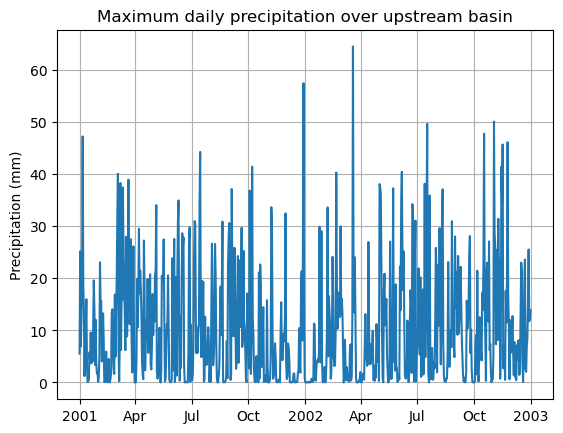

In [8]:
# Plot maximum daily precipitation to control values
max_daily_precip = ds_era5['precip'].resample(time='D').sum(dim='time').max(dim=['latitude', 'longitude']) # In mm

fig, ax = plt.subplots()

max_daily_precip.plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Maximum daily precipitation over upstream basin')
ax.grid()

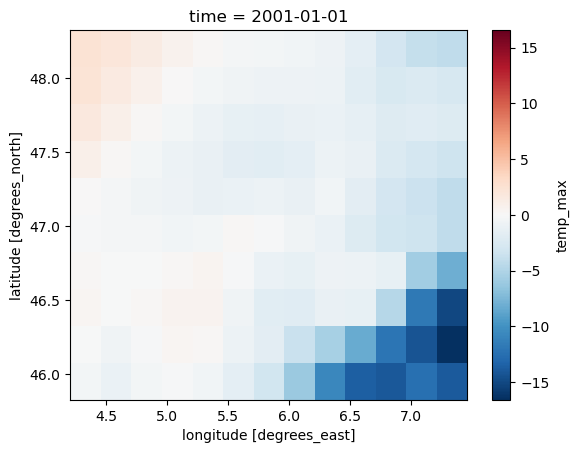

In [11]:
ds_era5['temp_max'].sel(time='2001-01-01T00:00:00.000000000').plot()